# 01 - Exploración inicial de los datos de ensayos clínicos

En este notebook se realiza el análisis exploratorio de los datos (EDA) del conjunto de datos obtenido a partir de la API de ClinicalTrials.gov.

Objetivos:

- Cargar el dataset desde `data/clean/`.
- Verificar la estructura (número de filas, columnas, tipos de datos).
- Analizar valores faltantes.
- Explorar la distribución de variables clave (fase, condición, país, sponsor, etc.).
- Identificar problemas de calidad de datos relevantes para el modelado posterior.


In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

import ast

import requests

plt.style.use("default")
pd.set_option("display.max_columns", None)

In [2]:
# Definimos rutas:

PROJECT_ROOT = Path().resolve().parent
DATA_CLEAN_DIR = PROJECT_ROOT / "data" / "clean"

CLEAN_FILENAME = "clinicaltrials_clean.csv"
data_path = DATA_CLEAN_DIR / CLEAN_FILENAME

FIGURES_DIR = PROJECT_ROOT / "reports" / "figures"
FIGURES_DIR.mkdir(exist_ok=True)

mesh_path = PROJECT_ROOT / "data" / "external" / "d2025.bin"
mesh_path.parent.mkdir(parents=True, exist_ok=True)

path = Path(data_path)
if not path.exists():
    raise FileNotFoundError(f"Archivo no encontrado: {path}")
    
if path.suffix.lower() == ".csv":
    df = pd.read_csv(path, low_memory = False)

else:
    raise ValueError(f"La extensión del archivo no es correcta (se espera .csv): {path.suffix}")

In [3]:
# Primer vistazo a los datos:

print("Shape:", df.shape)
print("\nDtypes:\n", df.dtypes)
print("\nSample rows:\n", df.head(5))
print("\nMissing values per column (top 30):")
print(df.isna().sum().sort_values(ascending=False).head(30))


Shape: (204675, 38)

Dtypes:
 NCTId                       object
BriefTitle                  object
OfficialTitle               object
OverallStatus               object
LastKnownStatus             object
StartDate                   object
PrimaryCompletionDate       object
CompletionDate              object
StudyFirstSubmitDate        object
LastUpdateSubmitDate        object
LeadSponsorName             object
LeadSponsorClass            object
BriefSummary                object
Condition                   object
Keyword                     object
StudyType                   object
Phase                       object
DesignAllocation            object
DesignInterventionModel     object
DesignPrimaryPurpose        object
DesignMasking               object
DesignWhoMasked             object
EnrollmentCount            float64
InterventionName            object
PrimaryOutcomeMeasure       object
SecondaryOutcomeMeasure     object
EligibilityCriteria         object
HealthyVolunteers        

Vemos que algunos campos de fecha no tiene día, y que algunos campos tienen muchos vacíos Tambien vemos que hay campos como Phase o Condition que son listas de valores, por lo que se tendrá que "explotar" esos campos.

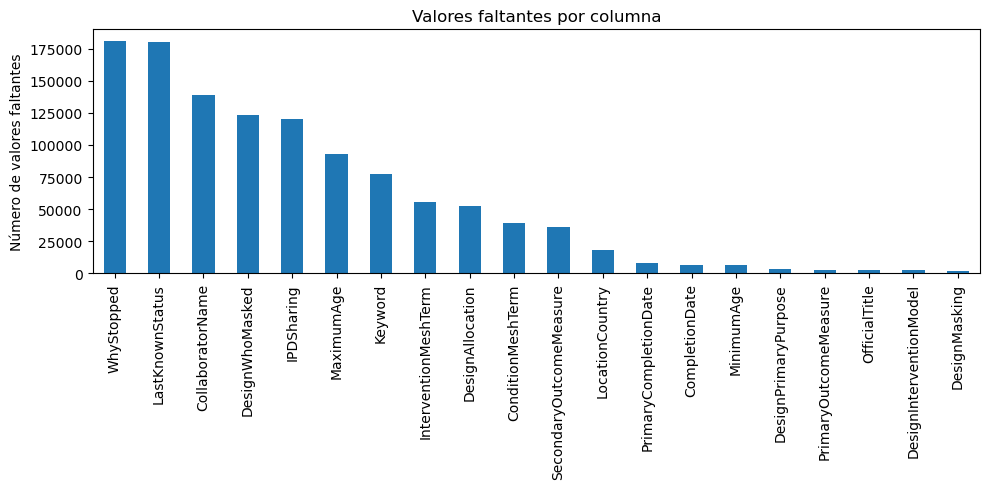

In [4]:
# Vemos que columnas acumulan mayor número de valores faltantes

missing = df.isna().sum().sort_values(ascending=False)
missing = missing[missing > 0].head(20)

if missing.empty:
    print("No hay valores faltantes.")

else:
    plt.figure(figsize=(10, 5))
    missing.plot(kind="bar")
    plt.title("Valores faltantes por columna")
    plt.ylabel("Número de valores faltantes")
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / "distribucion_valores_faltantes.png", dpi=300, bbox_inches="tight")
    plt.show()

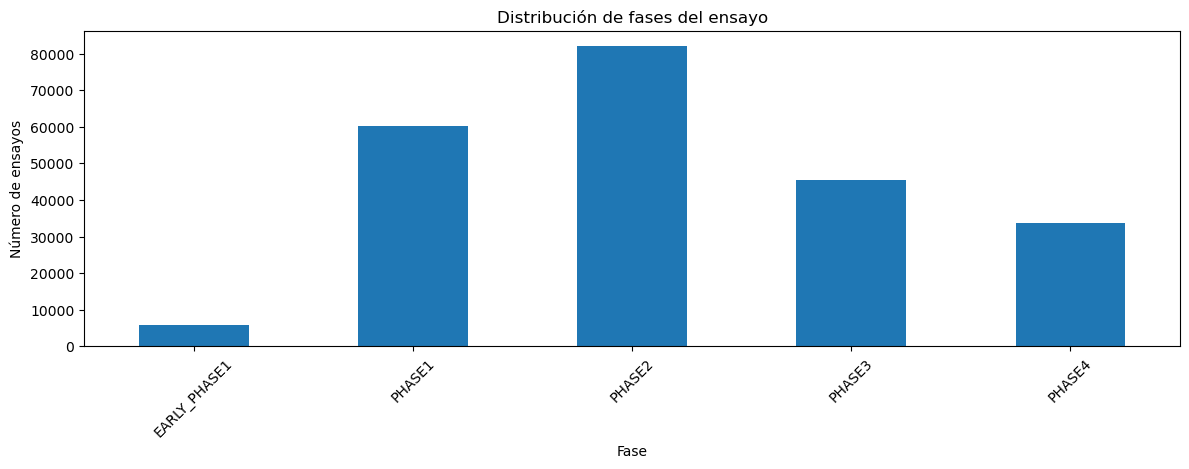

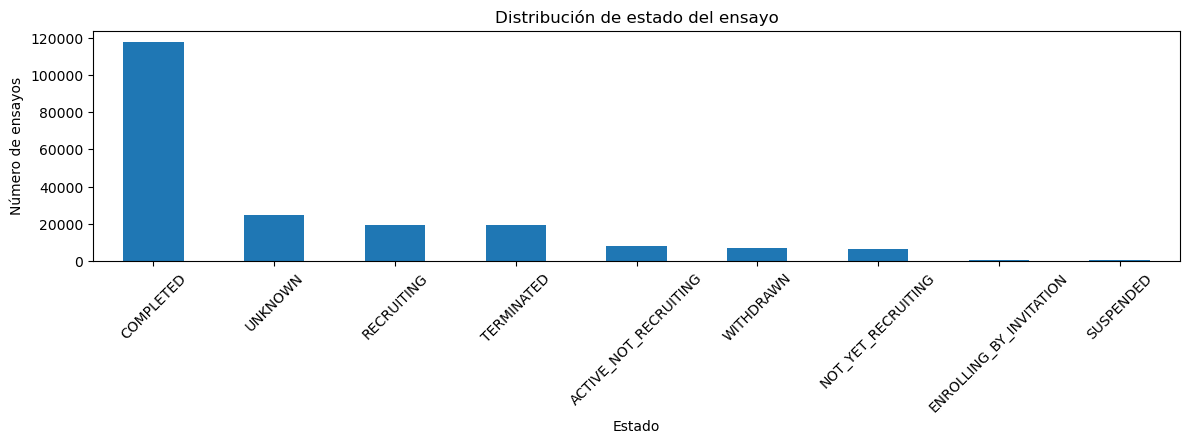

In [5]:
# A continuación se observa la dsitribución de los ensayos segun su fase o estado:

# Fase del ensayo
if "Phase" in df.columns:
    plt.figure(figsize=(12, 5))
    phases = (df["Phase"].dropna().apply(lambda x: ast.literal_eval(x) if x.startswith("[") else [x]).explode().str.strip())
    phases.value_counts(dropna=False).sort_index().plot(kind="bar")
    plt.title("Distribución de fases del ensayo")
    plt.xlabel("Fase")
    plt.ylabel("Número de ensayos")
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.savefig(FIGURES_DIR / "distribucion_phase.png", dpi=300, bbox_inches="tight")
    plt.show()

# Estado del ensayo 
if "OverallStatus" in df.columns:
    plt.figure(figsize=(12, 5))
    df["OverallStatus"].value_counts(dropna=False).plot(kind="bar")
    plt.title("Distribución de estado del ensayo")
    plt.xlabel("Estado")
    plt.ylabel("Número de ensayos")
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.savefig(FIGURES_DIR / "distribucion_overall_status.png", dpi=300, bbox_inches="tight")
    plt.show()


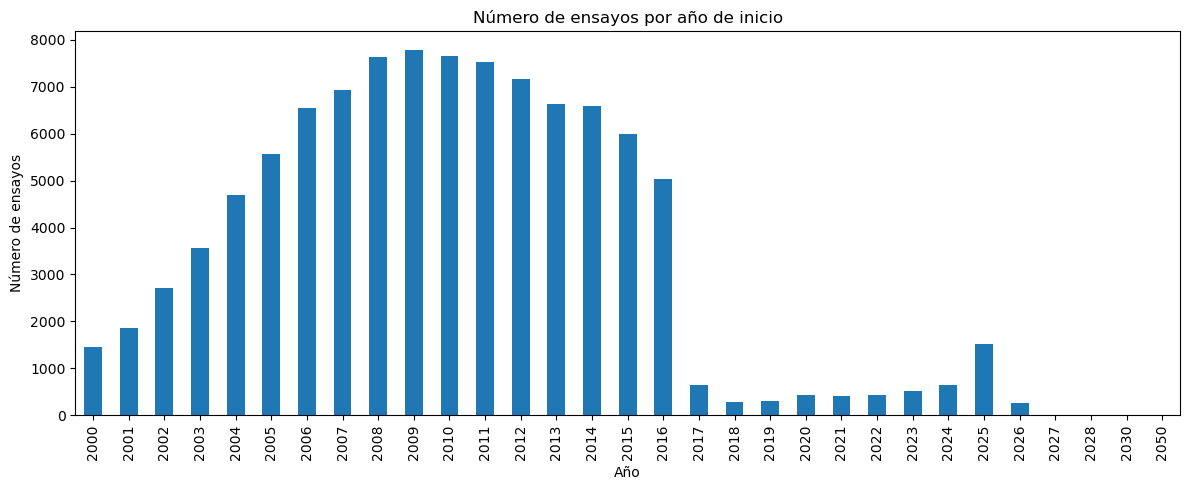

In [6]:
# representación similar teniendo en cuenta el año de inicio:

df_date = df.copy()

for col in ["StartDate", "PrimaryCompletionDate", "CompletionDate", "LastUpdateSubmitDate", "StudyFirstSubmitDate"]:
    if col in df_date.columns:
        df_date[col] = pd.to_datetime(df_date[col], errors="coerce")

        
if "StartDate" in df_date.columns:
    plt.figure(figsize=(12, 5))
    df_date["StartDate"].dt.year.dropna().astype(int).value_counts().sort_index().plot(kind="bar")
    plt.title("Número de ensayos por año de inicio")
    plt.xlabel("Año")
    plt.ylabel("Número de ensayos")
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / "distribucion_start_date.png", dpi=300, bbox_inches="tight")
    plt.show()


In [7]:
# A partir de 2017 cae mucho el número de estudios, y eso es debido al formato de las fechas. A continuación se corrigen las fechas

date_columns = ["StartDate", "PrimaryCompletionDate", "CompletionDate", "LastUpdateSubmitDate", "StudyFirstSubmitDate"]


for col in date_columns:
    if col in df.columns:
        s = df[col].astype("string").str.strip()

        quality = pd.Series("full", index=df.index)

        quality[s.isna()] = "missing"
        quality[s.str.len() == 4] = "solo año"
        quality[s.str.len() == 7] = "año_mes"

        df[col + "_quality"] = quality

for col in date_columns:
    if col in df.columns:
        s = df[col].astype("string").str.strip()
        s_norm = s.copy()

        mask_year = s.str.len() == 4
        mask_year_month = s.str.len() == 7

        s_norm[mask_year] = s_norm[mask_year] + "-01-01"
        s_norm[mask_year_month] = s_norm[mask_year_month] + "-01"

        df[col] = pd.to_datetime(s_norm, errors="coerce")

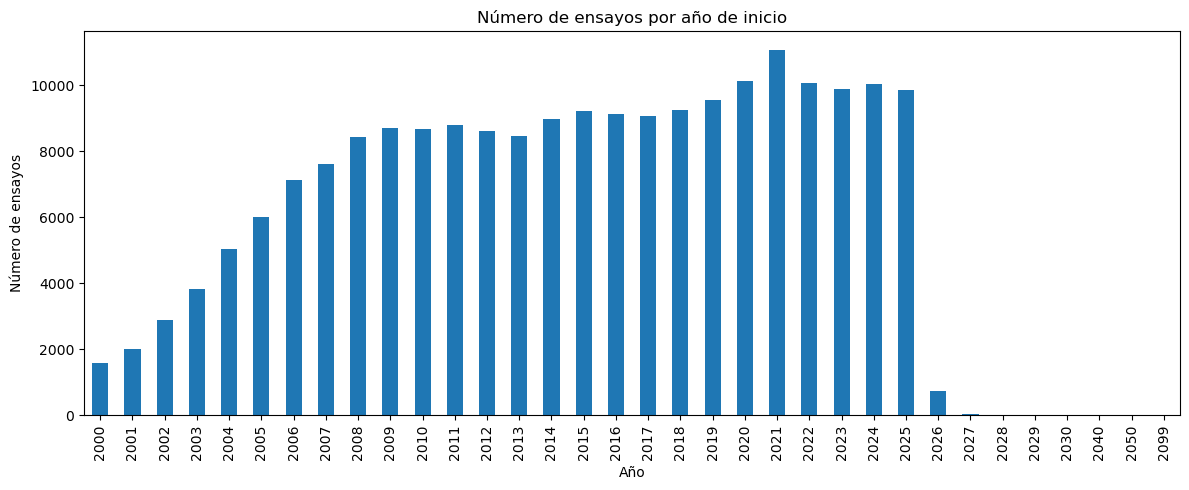

In [8]:
if "StartDate" in df.columns:
    plt.figure(figsize=(12, 5))
    df["StartDate"].dt.year.value_counts().sort_index().plot(kind="bar")
    plt.title("Número de ensayos por año de inicio")
    plt.xlabel("Año")
    plt.ylabel("Número de ensayos")
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / "distribucion_start_date_2.png", dpi=300, bbox_inches="tight")
    plt.show()

El grafico anterior muesta valores mas alineados con lo esperado, vemos pocos ensayos que empiecen en 2026 o adelante.

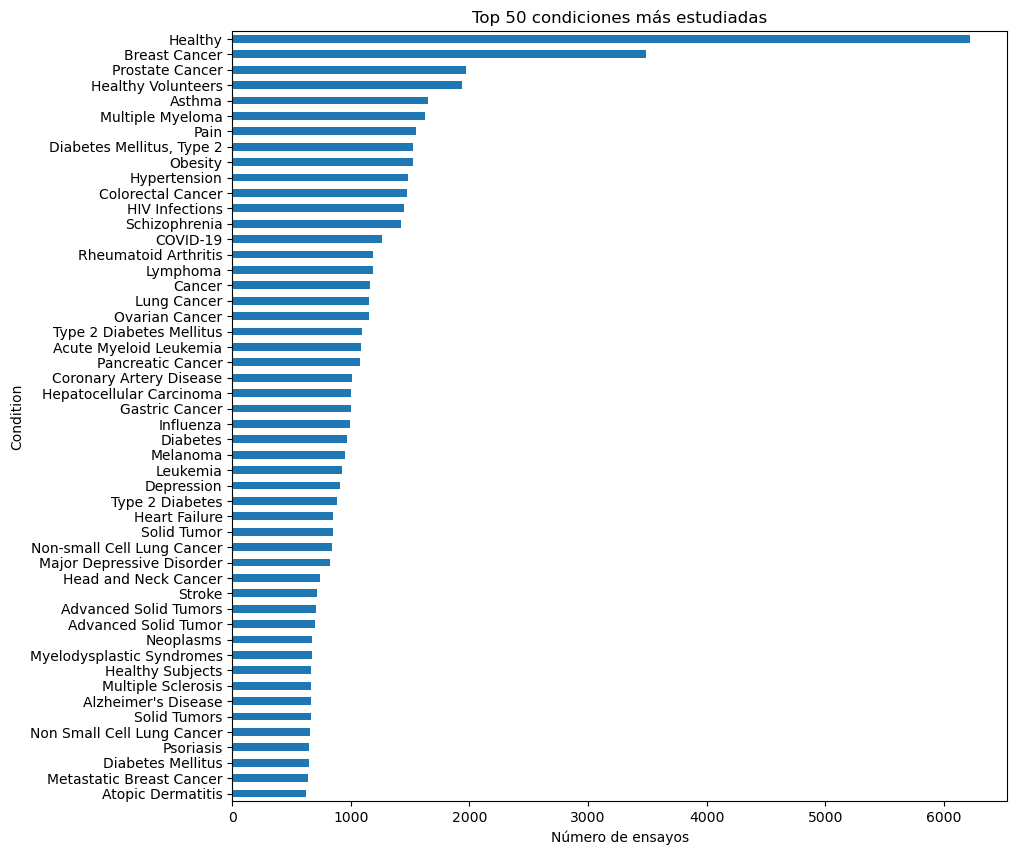

In [10]:
# Top condiciones
if "Condition" in df.columns:
    all_conditions = (
        df["Condition"]
        .dropna()
        .apply(lambda x: ast.literal_eval(x))
        .explode()
        .str.strip()
    )
    
    top_conditions = all_conditions.value_counts().head(50)

    plt.figure(figsize=(10,10))
    top_conditions.plot(kind="barh")
    plt.gca().invert_yaxis()
    plt.title("Top 50 condiciones más estudiadas")
    plt.xlabel("Número de ensayos")
    plt.savefig(FIGURES_DIR / "distribucion_condition.png", dpi=300, bbox_inches="tight")
    plt.show()

    top_conditions


Observamos que hay valores parecidos ("Diabetes Mellitus, Type 2", "Type 2 Diabetes Mellitus", "Diabetes", "Type 2 Diabetes", "Diabetes Mellitus"), ("Advanced Solid Tumor", "Advanced Solid Tumors"), ("Healthy", "Healty Subjects"), ("Non Small Cell Lung Cancer", "Non-mall Cell Lung Cancer")

In [11]:
# Para estandarizar nomenclatura, como el MEDDRA es de pago, se usara el .bin de ASCIMESH de NIH NLM

# Desccargamos el fichero:
url = "https://nlmpubs.nlm.nih.gov/projects/mesh/MESH_FILES/asciimesh/d2025.bin"

response = requests.get(url)
with open(mesh_path, "wb") as f:
    f.write(response.content)

In [12]:
def load_mesh_ascii(path):
    mesh_map = {}
    current_mh = None

    with open(path, encoding="utf-8") as f:
        for line in f:
            line = line.strip()

            if line.startswith("MH = "):
                current_mh = line.replace("MH = ", "").strip()
                mesh_map[current_mh.lower()] = current_mh

            elif line.startswith("ENTRY = ") and current_mh:
                entry = line.replace("ENTRY = ", "").split("|")[0].strip()
                mesh_map[entry.lower()] = current_mh

    return mesh_map

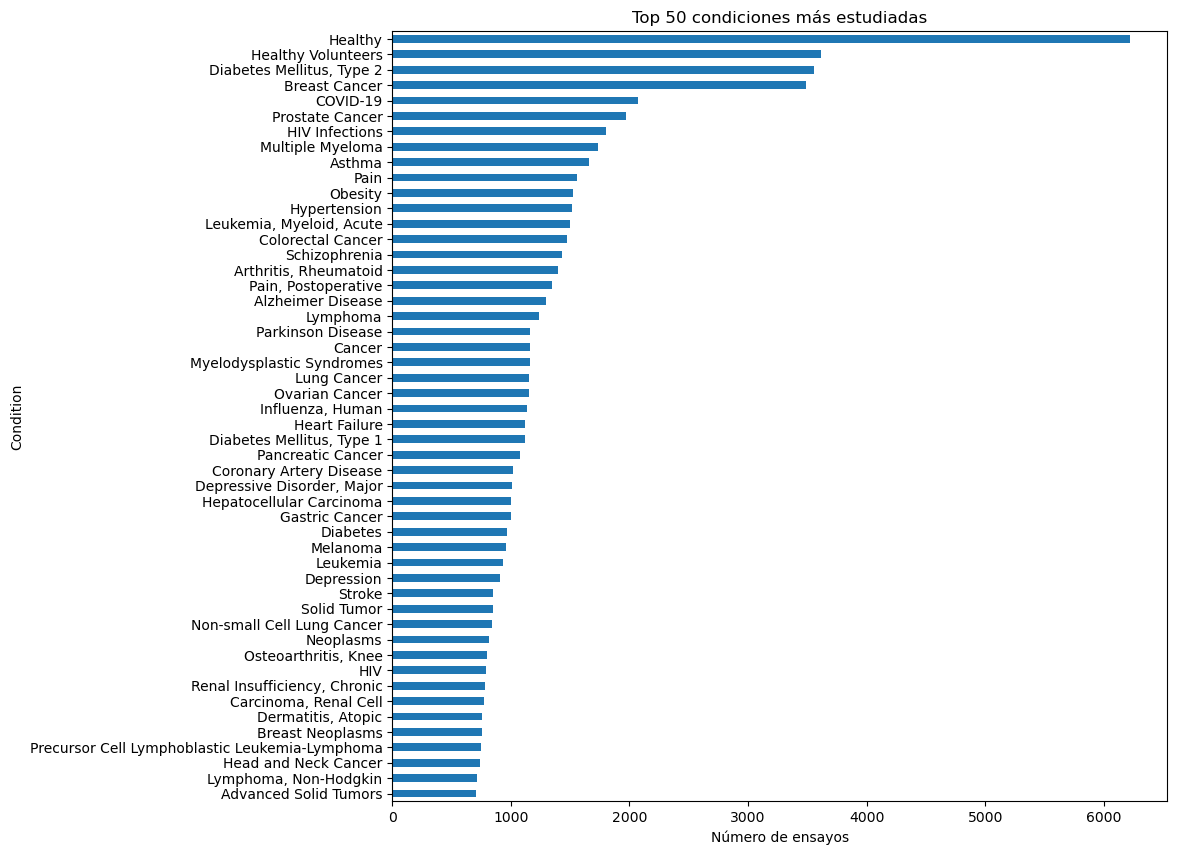

In [13]:
mesh_map = load_mesh_ascii(mesh_path)

# Top condiciones
if "Condition" in df.columns:
    all_conditions = (
        df["Condition"]
        .dropna()
        .apply(lambda x: ast.literal_eval(x))
        .explode()
        .str.strip()
    )
    
    top_conditions = (all_conditions.str.lower().map(mesh_map).fillna(all_conditions)).value_counts().head(50)

    plt.figure(figsize=(10,10))
    top_conditions.plot(kind="barh")
    plt.gca().invert_yaxis()
    plt.title("Top 50 condiciones más estudiadas")
    plt.xlabel("Número de ensayos")
    plt.savefig(FIGURES_DIR / "distribucion_condition2.png", dpi=300, bbox_inches="tight")
    plt.show()

    top_conditions


Ahora se ha conseguido unificar mas los valores.

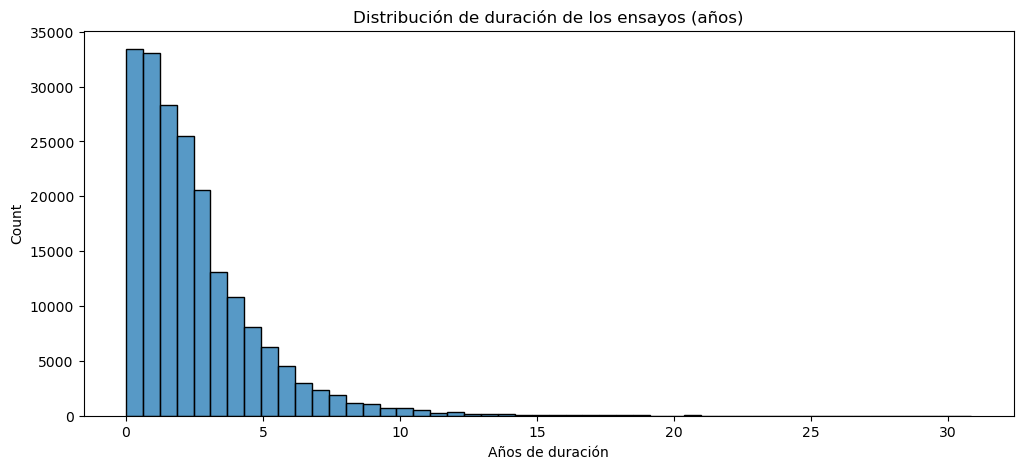

count    196714.000000
mean          2.500335
std           2.276787
min           0.000000
25%           0.920548
50%           1.923288
75%           3.397260
max          30.852055
Name: DurationDays, dtype: float64

In [14]:
# Duración del ensayo en años

df["DurationDays"] = (df["PrimaryCompletionDate"] - df["StartDate"]).dt.days

plt.figure(figsize=(12,5))
# Calculamos en años
sns.histplot(df["DurationDays"].dropna()/365, bins=50)
plt.title("Distribución de duración de los ensayos (años)")
plt.xlabel("Años de duración")
plt.savefig(FIGURES_DIR / "distribucion_duración.png", dpi=300, bbox_inches="tight")
plt.show()

(df["DurationDays"]/365).describe()


De media los ensayos se tardan 2 años y medio, y el 50% tiene una duración inferior a 2 años.

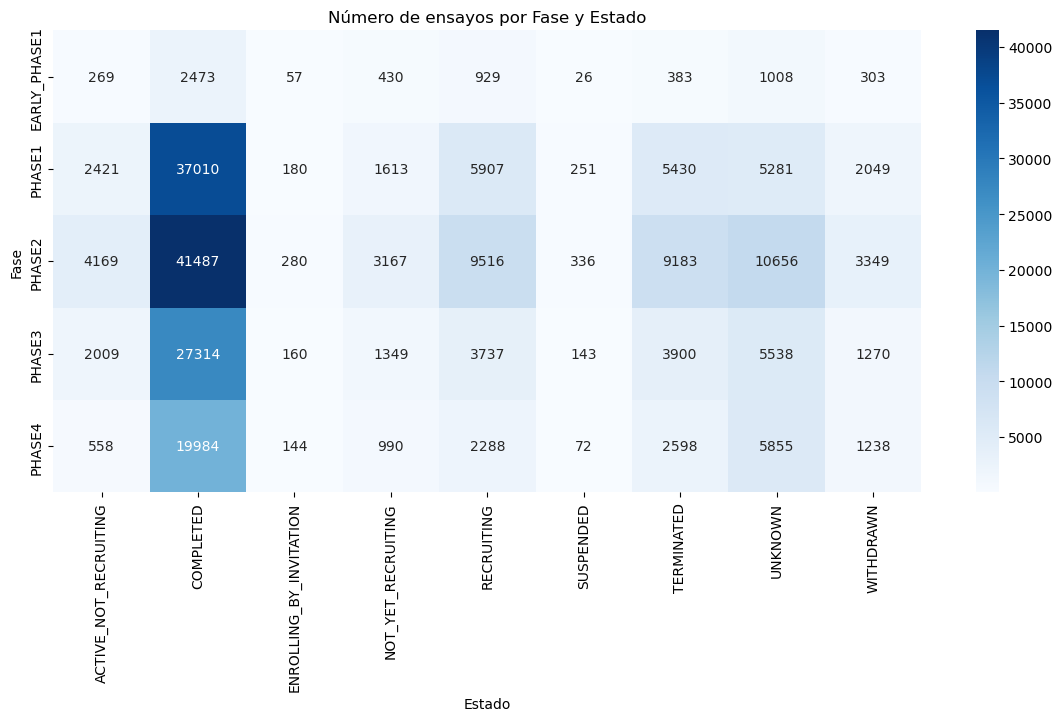

In [15]:
# Fase vs Estado
if "Phase" in df.columns and "OverallStatus" in df.columns:
    phases = (
        df["Phase"].dropna().apply(lambda x: ast.literal_eval(x) if x.startswith("[") else [x])
        .explode().str.strip())

    temp = pd.DataFrame({"OverallStatus": df["OverallStatus"],"Phase": phases}).dropna()
    
    cross_tab = pd.crosstab(temp["Phase"], temp["OverallStatus"])

    plt.figure(figsize=(14,6))
    sns.heatmap(cross_tab, annot=True, cmap="Blues", fmt="d")
    plt.title("Número de ensayos por Fase y Estado")
    plt.xlabel("Estado")
    plt.ylabel("Fase")
    plt.savefig(FIGURES_DIR / "distribucion_Fase_Estado.png", dpi=300, bbox_inches="tight")
    plt.show()

    cross_tab


La mayor parte de los datos estan "Completed" y/o son de a Phase 2.

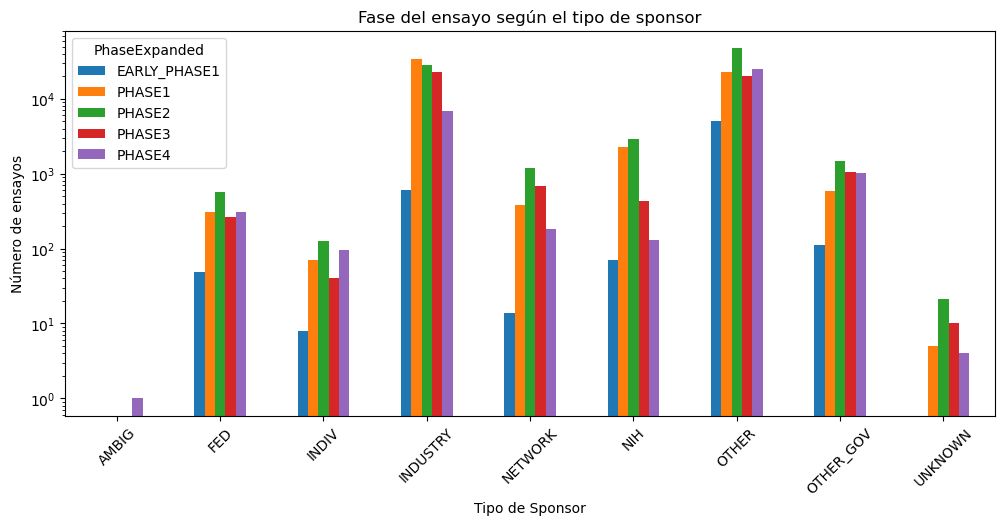

In [16]:
# Sponsor vs fase
if "LeadSponsorClass" in df.columns and "Phase" in df.columns:
    phases = (
        df["Phase"].dropna().apply(lambda x: ast.literal_eval(x) if x.startswith("[") else [x])
        .explode().str.strip())

    
    temp = pd.DataFrame({"LeadSponsorClass": df["LeadSponsorClass"],"PhaseExpanded": phases}).dropna()

    sponsor_phase = pd.crosstab(temp["LeadSponsorClass"], temp["PhaseExpanded"])

    sponsor_phase.plot(kind="bar", figsize=(12,5))
    plt.title("Fase del ensayo según el tipo de sponsor")
    plt.xlabel("Tipo de Sponsor")
    plt.ylabel("Número de ensayos")
    plt.xticks(rotation=45)
    plt.yscale("log")
    plt.savefig(FIGURES_DIR / "distribucion_Fase_Sponsor.png", dpi=300, bbox_inches="tight")
    plt.show()

    sponsor_phase


In [ ]:
Todos los tipos de Sponsor siguen un mismo patrón, donde predomina phase 1 y 2.

## Comentarios preliminares

- **Calidad de datos**:
  - Se observan valores faltantes en varias columnas clave, especialmente en las fechas (StartDate, PrimaryCompletionDate, CompletionDate) y en campos descriptivos (OfficialTitle, WhyStopped). Esto requiere aplicar reglas de parsing robustas y tratar valores nulos para evitar sesgos en el análisis temporal.
  - La columna Condition presenta una nomenclatura muy heterogénea (sinónimos, variaciones ortográficas, formatos tipo lista). Para reducir redundancia y mejorar la interpretabilidad, se ha aplicado un proceso de normalización mediante MeSH (ASCII MeSH d2025.bin), que unifica miles de términos clínicos en descriptores estandarizados.
  - Existen duplicados potenciales asociados a versiones diferentes del mismo ensayo (misma NCT ID pero con variaciones en metadatos). Se han identificado y tratado para no inflar el recuento de estudios.
  - Algunas categorías como LeadSponsorClass y Study Type presentan valores inconsistentes o poco documentados, lo que obliga a una limpieza preliminar antes de generar estadísticas.

- **Distribución de fases**:
  - La distribución por fases es claramente desbalanceada.
      - Las fases Phase 2 y Phase 3 concentran la mayor parte de los ensayos, lo que refleja su papel central en el desarrollo clínico.
      - Las fases tempranas (Phase 1, Early Phase 1) son menos frecuentes.
      - Las fases combinadas (Phase 1/Phase 2, Phase 2/Phase 3) representan una proporción relevante y, tras la expansión correspondiente, contribuyen a varias fases simultáneamente.
  - Este desbalance tiene implicaciones metodológicas:
      - Afecta las comparaciones entre fases,
      - condiciona la elección de modelos predictivos,
      - y sugiere que los análisis deben interpretarse con cautela para fases con pocos datos.

- **Distribución temporal**:
  - Los ensayos muestran un incremento progresivo desde 2005–2007, coincidiendo con la expansión de ClinicalTrials.gov como repositorio obligatorio para estudios financiados con fondos públicos y privados.
  - A partir de 2010, el número de registros anuales se estabiliza en valores altos, reflejando una adopción global del repositorio.
  - En 2020–2021 se observa un pico significativo asociado a la pandemia de COVID-19, seguido de una normalización en los años posteriores
  - Antes del año 2000, el número de estudios es escaso y no representativo, por lo que dichos valores se interpretan con cautela.